# Модели машинного обучения

In [1]:
import warnings
import glob
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC
from skopt import BayesSearchCV
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

In [2]:
DATASETS_DIR = "datasets"
Q = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
files = glob.glob(DATASETS_DIR + "/*.csv", recursive=True)
print("\n".join(files))

datasets\data_0.2.csv
datasets\data_0.3.csv
datasets\data_0.4.csv
datasets\data_0.5.csv
datasets\data_0.6.csv
datasets\data_0.7.csv
datasets\data_0.8.csv
datasets\data_0.9.csv
datasets\data_1.0.csv


## CatBoost

In [3]:
LEARNING_RATE = 0.4

catboost_model = CatBoostClassifier(
    task_type="GPU",
    iterations=300,
    od_wait=10,
    od_type="Iter",
    learning_rate=LEARNING_RATE,
    allow_writing_files=False,
    silent=True,
)

In [4]:
catboost_accuracy_list = []

for file in tqdm(files):
    df = pd.read_csv(file)

    df[df.columns[:-1]] = scale(df[df.columns[:-1]])

    df_train, df_test = train_test_split(df, test_size=0.3)

    y_train = df_train.pop('noised')
    X_train = df_train
    y_test = df_test.pop('noised')
    X_test = df_test

    X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2)

    catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

    catboost_accuracy_list.append(accuracy_score(y_test, catboost_model.predict(X_test)))


100%|██████████| 9/9 [00:33<00:00,  3.74s/it]


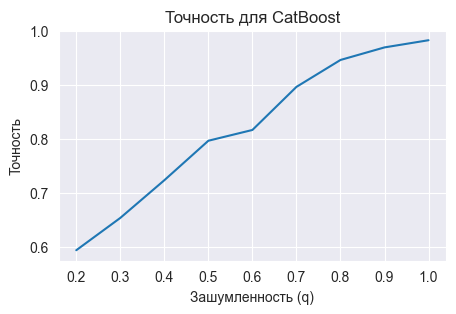

In [5]:
plt.figure(figsize=(5,3))
plt.title("Точность для CatBoost")
plt.ylabel("Точность")
plt.xlabel("Зашумленность (q)")
plt.plot(Q, catboost_accuracy_list)
plt.show()

## SVM

### Линейный метод SVM

In [6]:
gs = GridSearchCV(estimator=LinearSVC(),
                  param_grid= {
                      "C": [x / 10 for x in range(1, 11, 1)],
                      "max_iter": [x for x in range(10, 100, 10)],
                      "loss": ["hinge", "squared_hinge"],
                  },
                  scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

In [7]:
linear_svm_accuracy_list = []

for file in tqdm(files):
    df = pd.read_csv(file)

    df[df.columns[:-1]] = scale(df[df.columns[:-1]])

    df_train, df_test = train_test_split(df, test_size=0.3)

    y_train = df_train.pop('noised')
    X_train = df_train
    y_test = df_test.pop('noised')
    X_test = df_test

    gs.fit(X_train, y_train)

    best_liner_svm = gs.best_estimator_
    linear_svm_accuracy_list.append(cross_val_score(best_liner_svm, X_test, y_test, scoring="accuracy", n_jobs=-1).mean())

  0%|          | 0/9 [00:00<?, ?it/s]

Fitting 5 folds for each of 180 candidates, totalling 900 fits


 11%|█         | 1/9 [00:03<00:24,  3.00s/it]

Fitting 5 folds for each of 180 candidates, totalling 900 fits


 22%|██▏       | 2/9 [00:04<00:13,  1.96s/it]

Fitting 5 folds for each of 180 candidates, totalling 900 fits


 33%|███▎      | 3/9 [00:05<00:09,  1.61s/it]

Fitting 5 folds for each of 180 candidates, totalling 900 fits


 44%|████▍     | 4/9 [00:06<00:07,  1.44s/it]

Fitting 5 folds for each of 180 candidates, totalling 900 fits


 56%|█████▌    | 5/9 [00:07<00:05,  1.34s/it]

Fitting 5 folds for each of 180 candidates, totalling 900 fits


 67%|██████▋   | 6/9 [00:08<00:03,  1.24s/it]

Fitting 5 folds for each of 180 candidates, totalling 900 fits


 78%|███████▊  | 7/9 [00:09<00:02,  1.15s/it]

Fitting 5 folds for each of 180 candidates, totalling 900 fits


 89%|████████▉ | 8/9 [00:10<00:01,  1.07s/it]

Fitting 5 folds for each of 180 candidates, totalling 900 fits


100%|██████████| 9/9 [00:11<00:00,  1.29s/it]


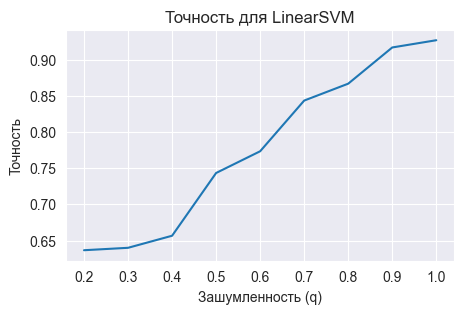

In [8]:
plt.figure(figsize=(5,3))
plt.title("Точность для LinearSVM")
plt.ylabel("Точность")
plt.xlabel("Зашумленность (q)")
plt.plot(Q, linear_svm_accuracy_list)
plt.show()

## Нелинейный SVM

In [9]:
gs = GridSearchCV(estimator=SVC(),
                  param_grid= {
                    "C": [x / 10 for x in range(1, 11, 1)],
                    "max_iter": [x for x in range(10, 100, 10)],
                  },
                  scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

In [10]:
svm_accuracy_list = []

for file in tqdm(files):
    df = pd.read_csv(file)

    df[df.columns[:-1]] = scale(df[df.columns[:-1]])

    df_train, df_test = train_test_split(df, test_size=0.3)

    y_train = df_train.pop('noised')
    X_train = df_train
    y_test = df_test.pop('noised')
    X_test = df_test

    gs.fit(X_train, y_train)
    best_svm = gs.best_estimator_
    svm_accuracy_list.append(cross_val_score(best_svm, X_test, y_test, scoring="accuracy", n_jobs=-1).mean())

  0%|          | 0/9 [00:00<?, ?it/s]

Fitting 5 folds for each of 90 candidates, totalling 450 fits


 11%|█         | 1/9 [00:00<00:05,  1.53it/s]

Fitting 5 folds for each of 90 candidates, totalling 450 fits


 22%|██▏       | 2/9 [00:01<00:04,  1.51it/s]

Fitting 5 folds for each of 90 candidates, totalling 450 fits


 33%|███▎      | 3/9 [00:01<00:03,  1.51it/s]

Fitting 5 folds for each of 90 candidates, totalling 450 fits


 44%|████▍     | 4/9 [00:02<00:03,  1.50it/s]

Fitting 5 folds for each of 90 candidates, totalling 450 fits


 56%|█████▌    | 5/9 [00:03<00:02,  1.48it/s]

Fitting 5 folds for each of 90 candidates, totalling 450 fits


 67%|██████▋   | 6/9 [00:04<00:02,  1.47it/s]

Fitting 5 folds for each of 90 candidates, totalling 450 fits


 78%|███████▊  | 7/9 [00:04<00:01,  1.47it/s]

Fitting 5 folds for each of 90 candidates, totalling 450 fits


 89%|████████▉ | 8/9 [00:05<00:00,  1.49it/s]

Fitting 5 folds for each of 90 candidates, totalling 450 fits


100%|██████████| 9/9 [00:06<00:00,  1.50it/s]


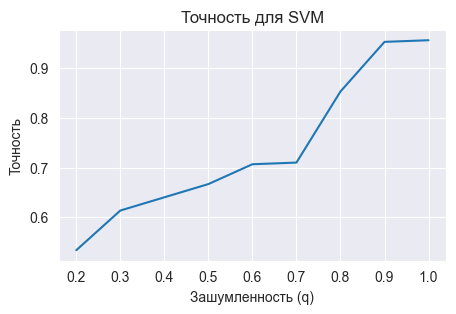

In [11]:
plt.figure(figsize=(5,3))
plt.title("Точность для SVM")
plt.ylabel("Точность")
plt.xlabel("Зашумленность (q)")
plt.plot(Q, svm_accuracy_list)
plt.show()